In [2]:
import sys
import os

cwd = os.getcwd()
h, _ = os.path.split(cwd)

sys.path.append(h)

from scripts import viz, metrics
from scripts.metrics import DetectionMetrics
from datetime import datetime

DATE = datetime.today().strftime('%d.%m_%H.%M')
SUP_RESULTS_FOLDER = f"supervised/{DATE}"

sup_metrics_dir = os.path.join(os.getcwd(), f'{SUP_RESULTS_FOLDER}/metrics')
sup_classifier_dir = os.path.join(os.getcwd(), f'{SUP_RESULTS_FOLDER}/classifiers')

os.makedirs(sup_metrics_dir, exist_ok=True)
os.makedirs(sup_classifier_dir, exist_ok=True)

print(DATE)

28.05_19.05


In [3]:
# const
n_runs = 3
n_epochs = 100
batch_size = 128

# Test Data

In [7]:
import numpy as np
import pandas as pd

SR_test = pd.read_csv("../data/evaluation/SR_test.csv")
extrabg_SR_test = pd.read_csv("../data/evaluation/extrabg_SR_test.csv")

SR_test.shape, extrabg_SR_test.shape

((60000, 6), (300000, 6))

Здесь мы **оставляем** тестовые данные как есть, просто потому что `preds_from_model` так хочет.

In [8]:
test_data = pd.concat([SR_test, extrabg_SR_test]).to_numpy()
test_target = test_data[:, -1]

test_data = test_data
test_data.shape

(360000, 6)

In [9]:
test_target.mean()

0.05555555555555555

# Functional

In [11]:
from scripts.nn_classifier import get_loaders
from sklearn.preprocessing import StandardScaler
from scripts.nn_classifier import train_classifier
from scripts.nn_classifier import preds_from_model


def get_preds(data_train, model_paths, clf_dir):
    clf_dir = os.path.join(os.getcwd(), clf_dir)
    sc = StandardScaler().fit(data_train)
    preds_matrix = preds_from_model(test_data, sc, model_paths, save_dir=clf_dir)
    return preds_matrix

# Supervised

For the supervised classifier the simulated SR data is used: 272k background events + 55k signal events

In [12]:
sig_train = pd.read_csv("../data/simulation/extrasig_SR_train.csv")
bkg_train = pd.read_csv("../data/simulation/extrabg_SR_train.csv")
sig_valid = pd.read_csv("../data/simulation/extrasig_SR_val.csv")
bkg_valid = pd.read_csv("../data/simulation/extrabg_SR_val.csv")

sig_train.shape, bkg_train.shape, sig_valid.shape, bkg_valid.shape

((27263, 6), (136429, 6), (27264, 6), (136429, 6))

Last column is signal/background label

In [13]:
train_sup_data = pd.concat([sig_train, bkg_train]).to_numpy()[:, 1:] # no m_jj
valid_sup_data = pd.concat([sig_valid, bkg_valid]).to_numpy()[:, 1:] # no m_jj

train_sup_target = train_sup_data[:, -1]
valid_sup_target = valid_sup_data[:, -1]

train_sup_data = train_sup_data[:, :-1]
valid_sup_data = valid_sup_data[:, :-1]

train_sup_data.shape, valid_sup_data.shape

((163692, 4), (163693, 4))

In [14]:
train_sup_target.mean(), valid_sup_target.mean()

(0.16655059501991545, 0.16655568655959632)

## NN

### Train

In [15]:
loaders, class_weight = get_loaders(train_sup_data, train_sup_target,
                                    valid_sup_data, valid_sup_target)

model_paths = train_classifier(loaders, class_weight, sup_classifier_dir, n_epochs, n_runs)

class_weight: [0.59991644 3.00209075]
Run 1...


epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Run 2...


epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Run 3...


epoch:   0%|          | 0/100 [00:00<?, ?it/s]

10
Run 1 minimum validation loss epochs: [91 74 99 87 88 85 82 79 76 97]
Run 2 minimum validation loss epochs: [67 66 98 97 75 70 85 69 78 96]
Run 3 minimum validation loss epochs: [89 85 84 96 65 77 80 72 73 94]


### Preds

In [16]:
sc = StandardScaler().fit(train_sup_data)
sup_preds = preds_from_model(test_data, sc, model_paths, save_dir=sup_classifier_dir)

### Metrics

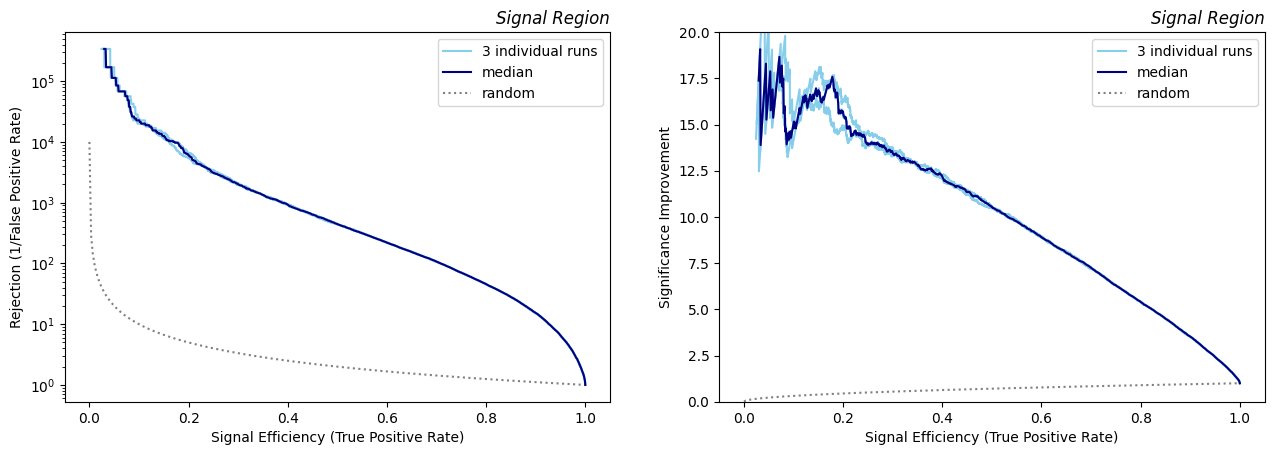

,AUC-ROC,AUC-PR,AUC-SIC
run 1,0.970976,0.822952,9.828368
run 2,0.971205,0.823222,9.728060
run 3,0.971114,0.823489,9.828751


In [17]:
from scripts.metrics import DetectionMetrics

det_metrics = DetectionMetrics()
det_metrics.show(sup_preds, test_target, save_dir=sup_metrics_dir)